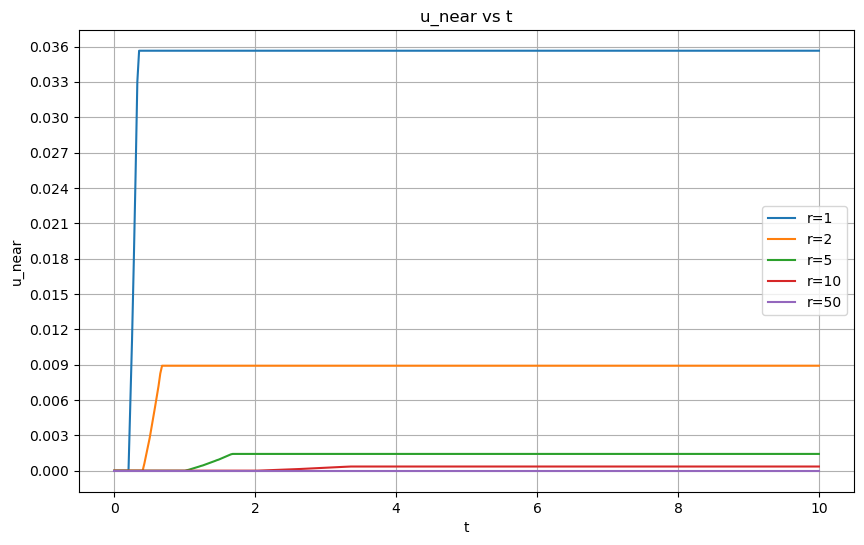

In [25]:
#ヘビサイドの階段関数
import numpy as np
import matplotlib.pyplot as plt

# 定数を定義
alpha = 5
beta = 3
N = 100
r_values = [1, 2, 5, 10, 50]

# u_nearの式を計算する関数
def calculate_u_near(r, t):
    total = 0
    for k in range(1, N+1):
        term = (1/beta - 1/alpha)/N  * (1/alpha + (1/beta - 1/alpha) * k/N) *np.heaviside(t - r/alpha - (r/beta - r/alpha)*k/N , 0) * 1/r**2
        total += term
    return total

# tの範囲とステップを定義
t_values = np.linspace(0, 10, 400)  # 例として0から10までの範囲でtを変動させる

# 各rの値に対するu_nearの値を計算しプロット
plt.figure(figsize=(10,6))
for r in r_values:
    u_near_values = [calculate_u_near(r, t) for t in t_values]
    plt.plot(t_values, u_near_values, label=f'r={r}')

plt.xlabel('t')
plt.ylabel('u_near')
plt.yticks(np.arange(0, 0.037, 0.003))
plt.title('u_near vs t')
plt.legend()
plt.grid(True)
plt.show()


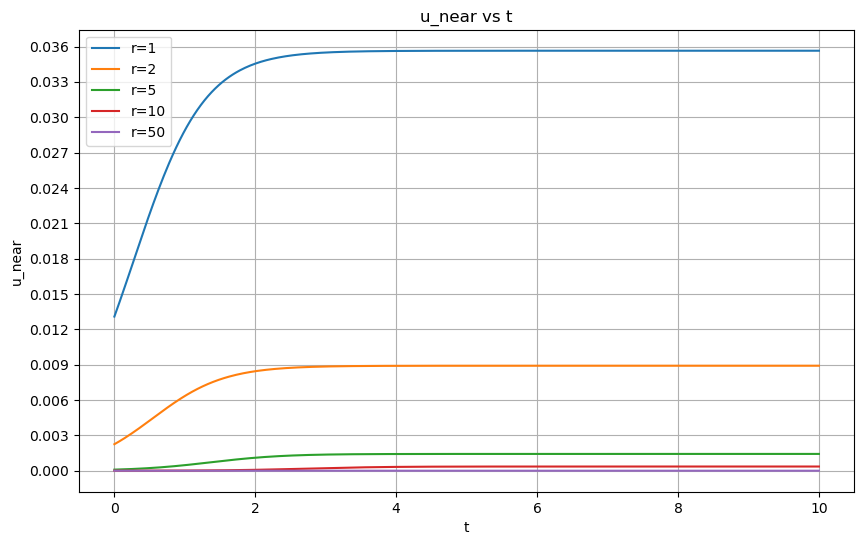

In [28]:
#ランプ関数(1/2(1+tanh(t)))
import numpy as np
import matplotlib.pyplot as plt

# 定数を定義
alpha = 5
beta = 3
N = 100
r_values = [1, 2, 5, 10, 50]

# u_nearの式を計算する関数
def calculate_u_near(r, t):
    total = 0
    for k in range(1, N+1):
        term = (1/beta - 1/alpha)/N  * (1/alpha + (1/beta - 1/alpha) * k/N) * 1/2 * ( 1 + np.tanh(t - r/alpha - (r/beta - r/alpha)*k/N)) * 1/r**2
        total += term
    return total

# tの範囲とステップを定義
t_values = np.linspace(0, 10, 400)  # 例として0から10までの範囲でtを変動させる

# 各rの値に対するu_nearの値を計算しプロット
plt.figure(figsize=(10,6))
for r in r_values:
    u_near_values = [calculate_u_near(r, t) for t in t_values]
    plt.plot(t_values, u_near_values, label=f'r={r}')

plt.xlabel('t')
plt.ylabel('u_near')
plt.yticks(np.arange(0, 0.037, 0.003))
plt.title('u_near vs t')
plt.legend()
plt.grid(True)
plt.show()


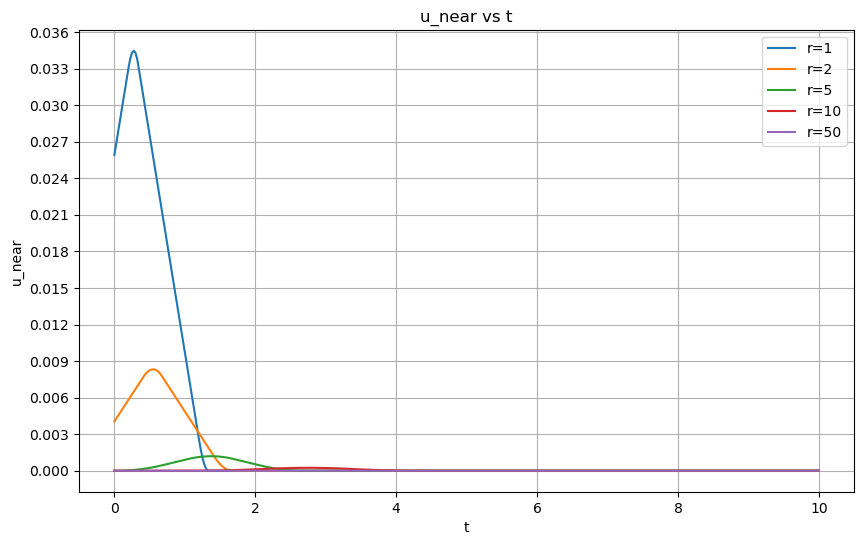

In [30]:
#三角形関数(max(1-|t|, 0))
import numpy as np
import matplotlib.pyplot as plt

# 定数を定義
alpha = 5
beta = 3
N = 100
r_values = [1, 2, 5, 10, 50]

# u_nearの式を計算する関数
def calculate_u_near(r, t):
    total = 0
    for k in range(1, N+1):
        term = (1/beta - 1/alpha)/N  * (1/alpha + (1/beta - 1/alpha) * k/N) * np.maximum(1-  np.abs(t - r/alpha - (r/beta - r/alpha)*k/N), 0) * 1/r**2
        total += term
    return total

# tの範囲とステップを定義
t_values = np.linspace(0, 10, 400)  # 例として0から10までの範囲でtを変動させる

# 各rの値に対するu_nearの値を計算しプロット
plt.figure(figsize=(10,6))
for r in r_values:
    u_near_values = [calculate_u_near(r, t) for t in t_values]
    plt.plot(t_values, u_near_values, label=f'r={r}')

plt.xlabel('t')
plt.ylabel('u_near')
plt.yticks(np.arange(0, 0.037, 0.003))
plt.title('u_near vs t')
plt.legend()
plt.grid(True)
plt.show()


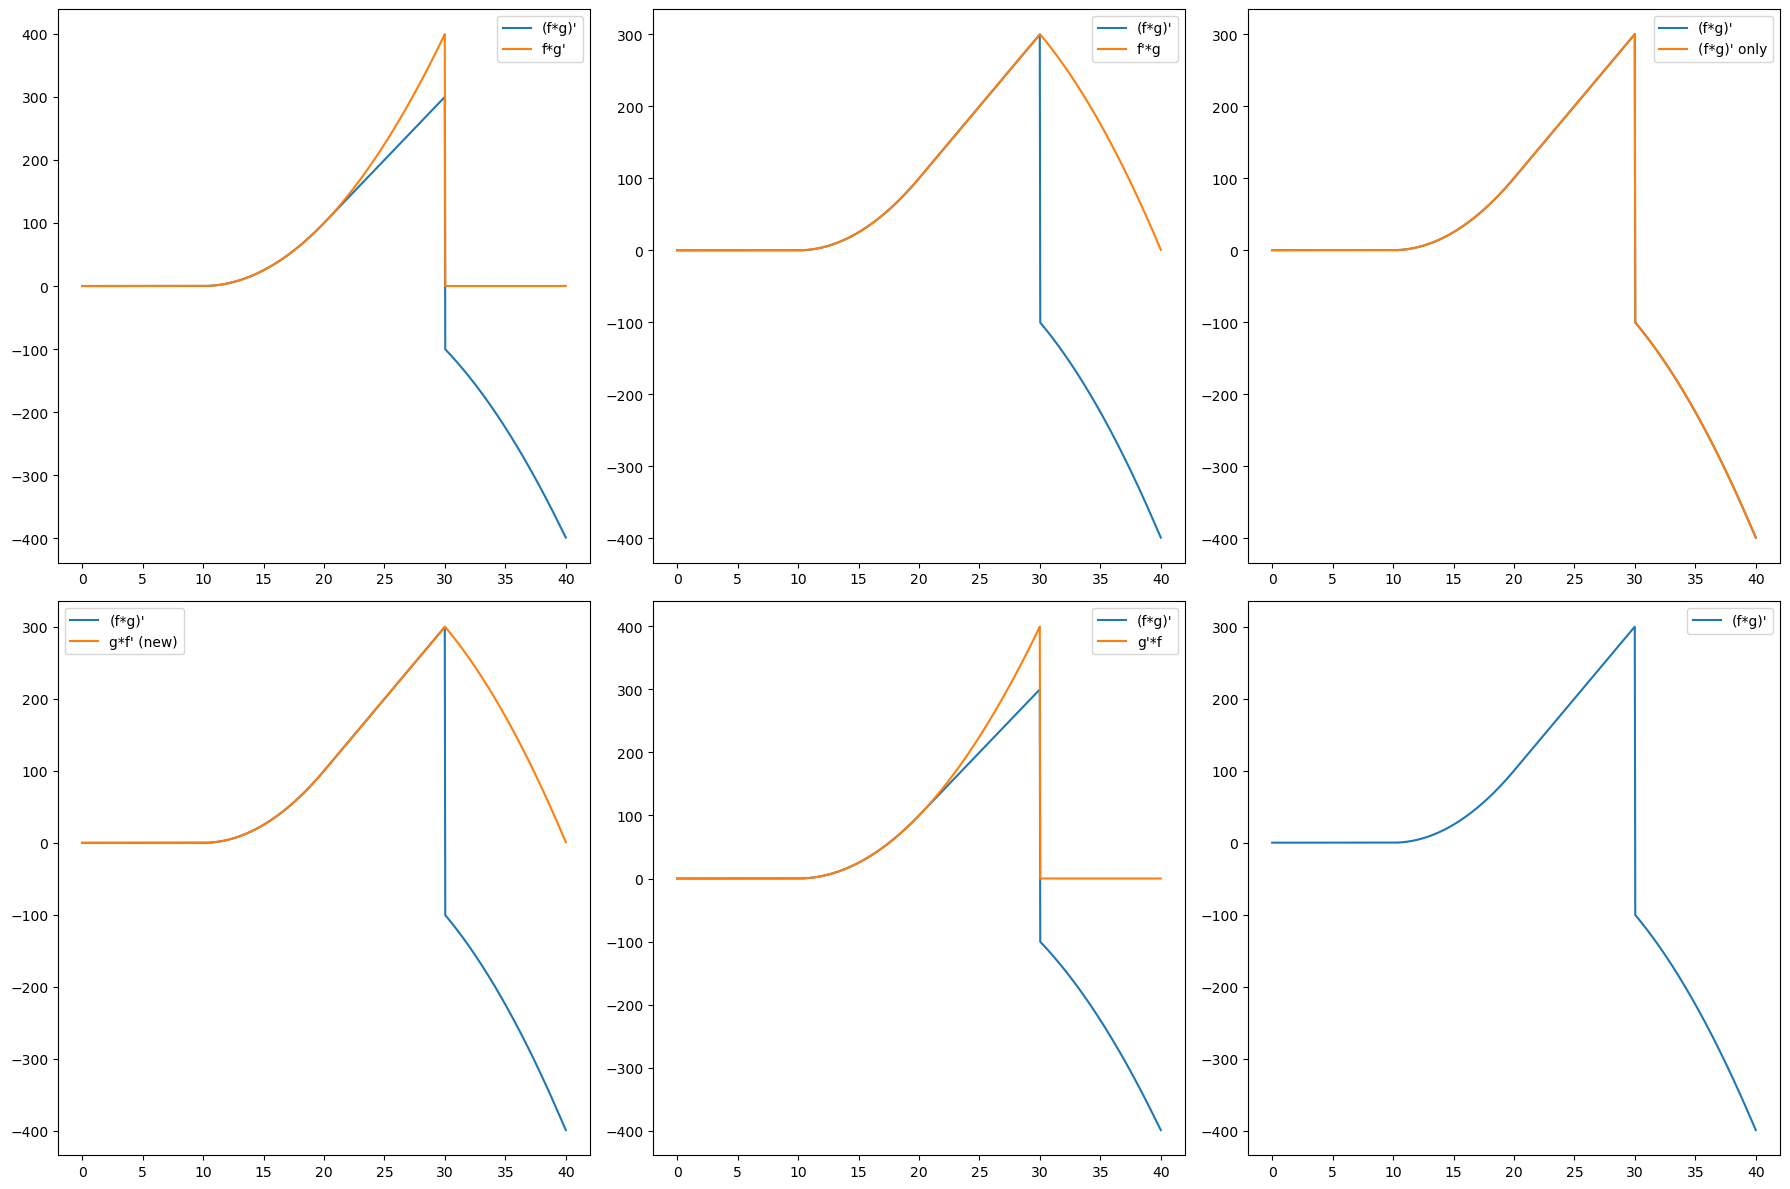

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Analytical functions
def f(x):
    return x**2

def g(x):
    return np.heaviside(x - 10, 1)

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots
for ax in axs.flat:
    ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f' (new)")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Plot only (f*g)' in the last subplot
axs[0, 2].plot(x_full, d_conv, label="(f*g)' only")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


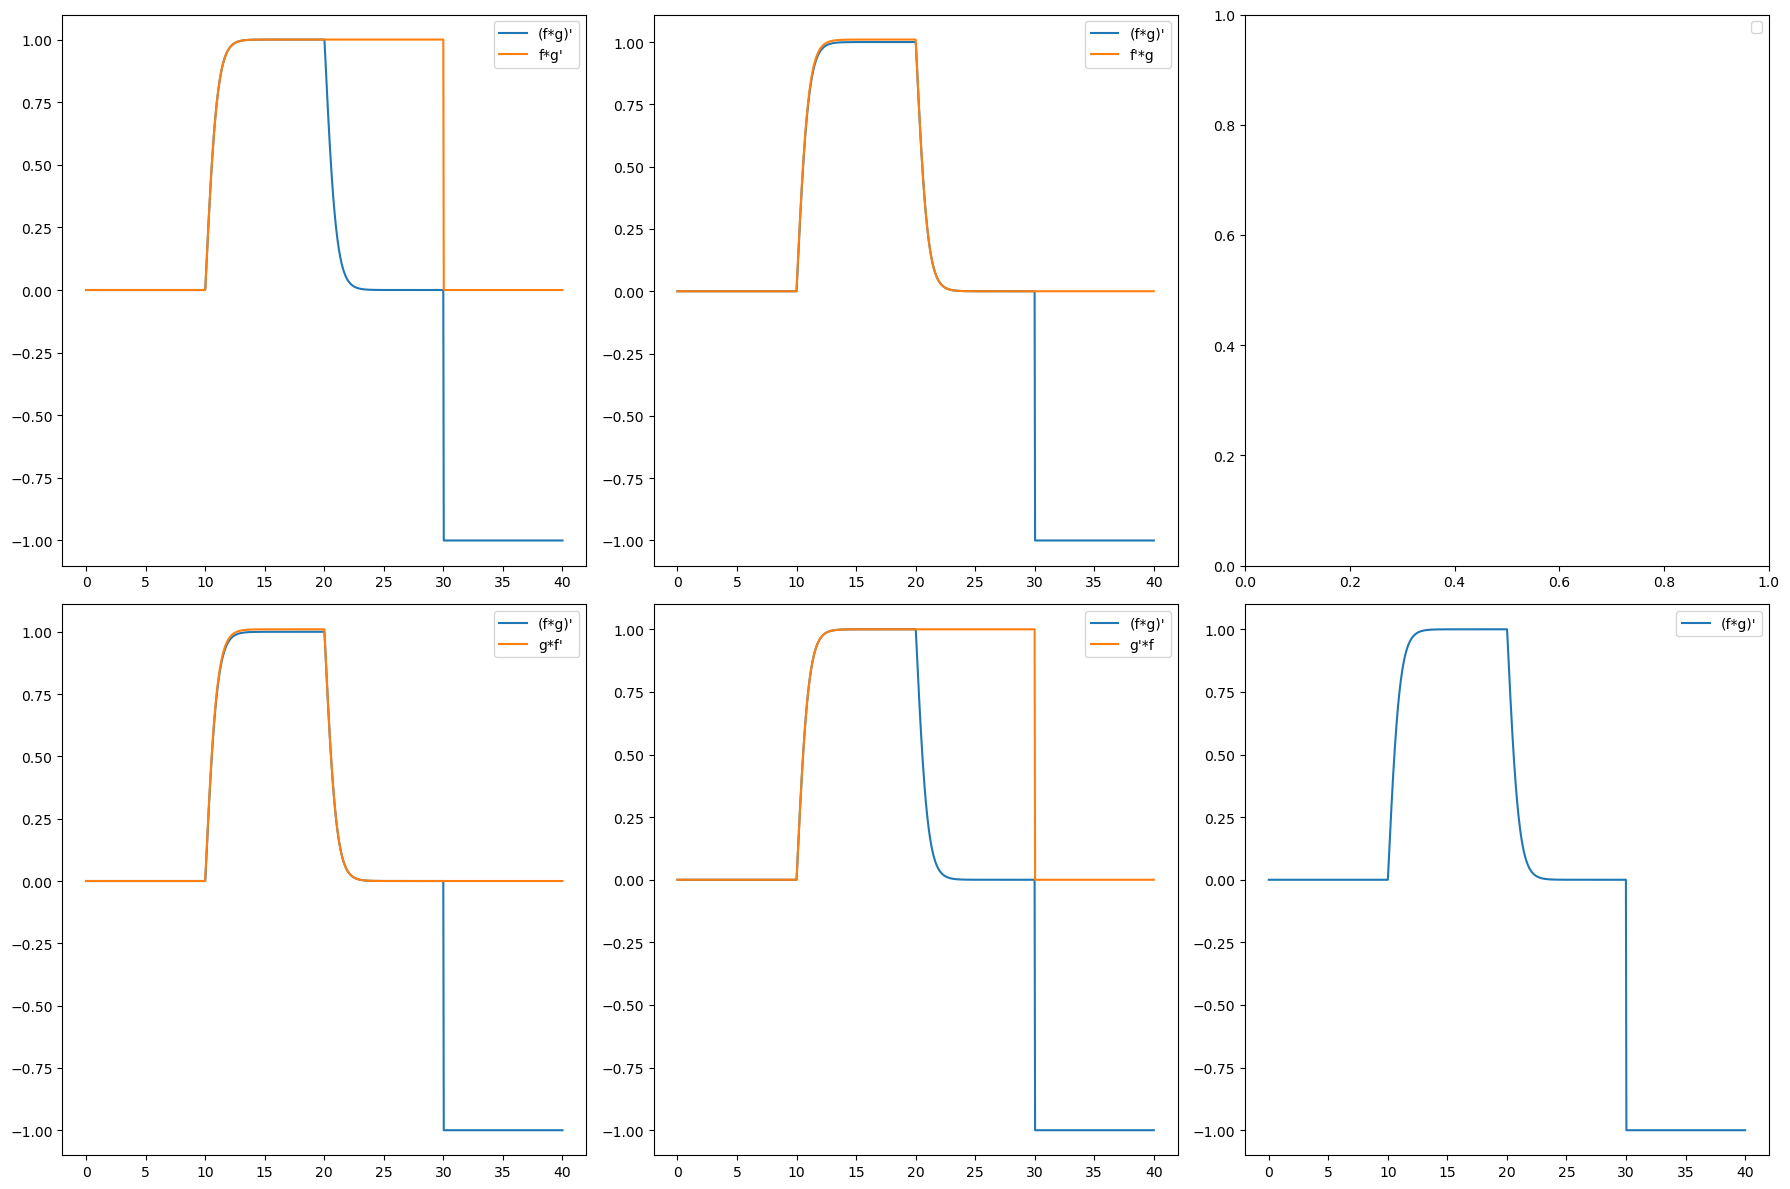

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Analytical functions
def f(x):
    return np.tanh(x)

def g(x):
    return np.heaviside(x - 10, 1)

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


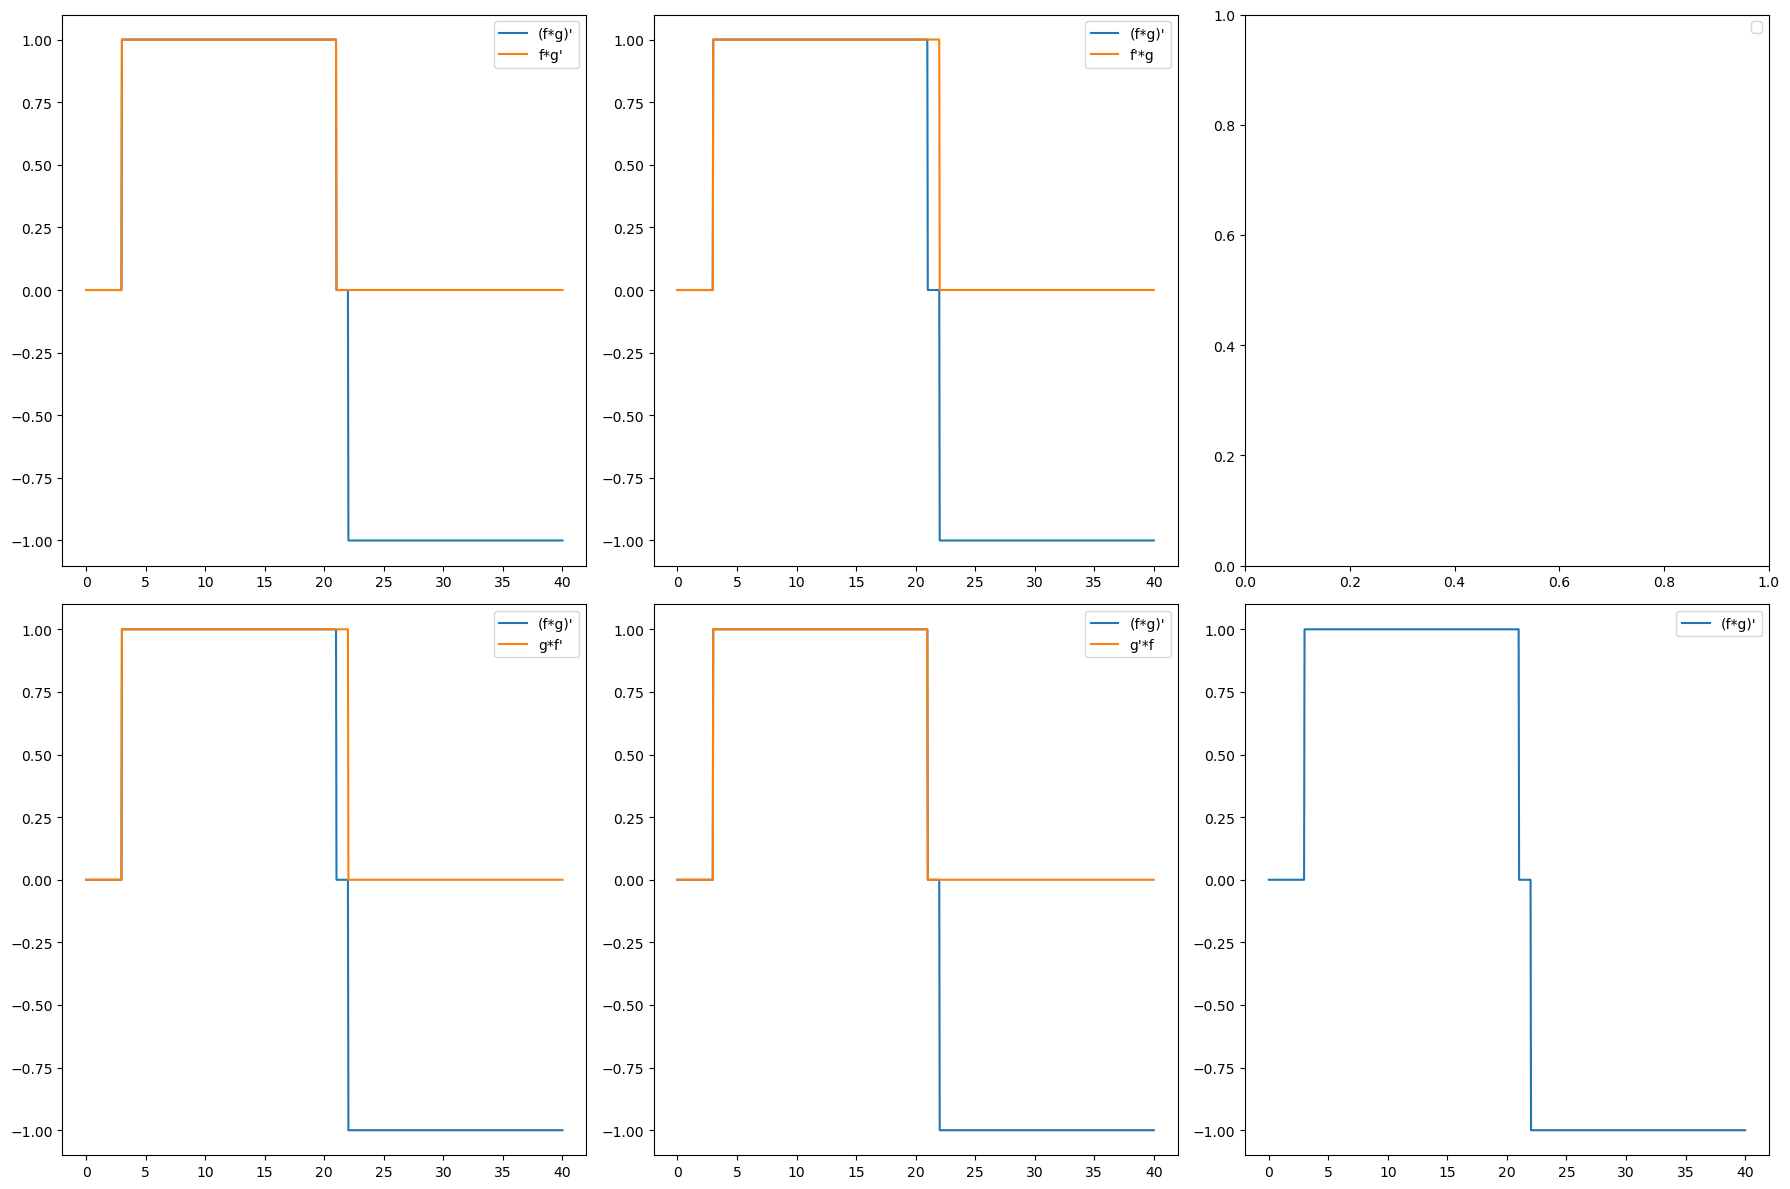

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Analytical functions
def f(x):
    return np.heaviside(x - 2, 1)

def g(x):
    return np.heaviside(x - 1, 1)

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


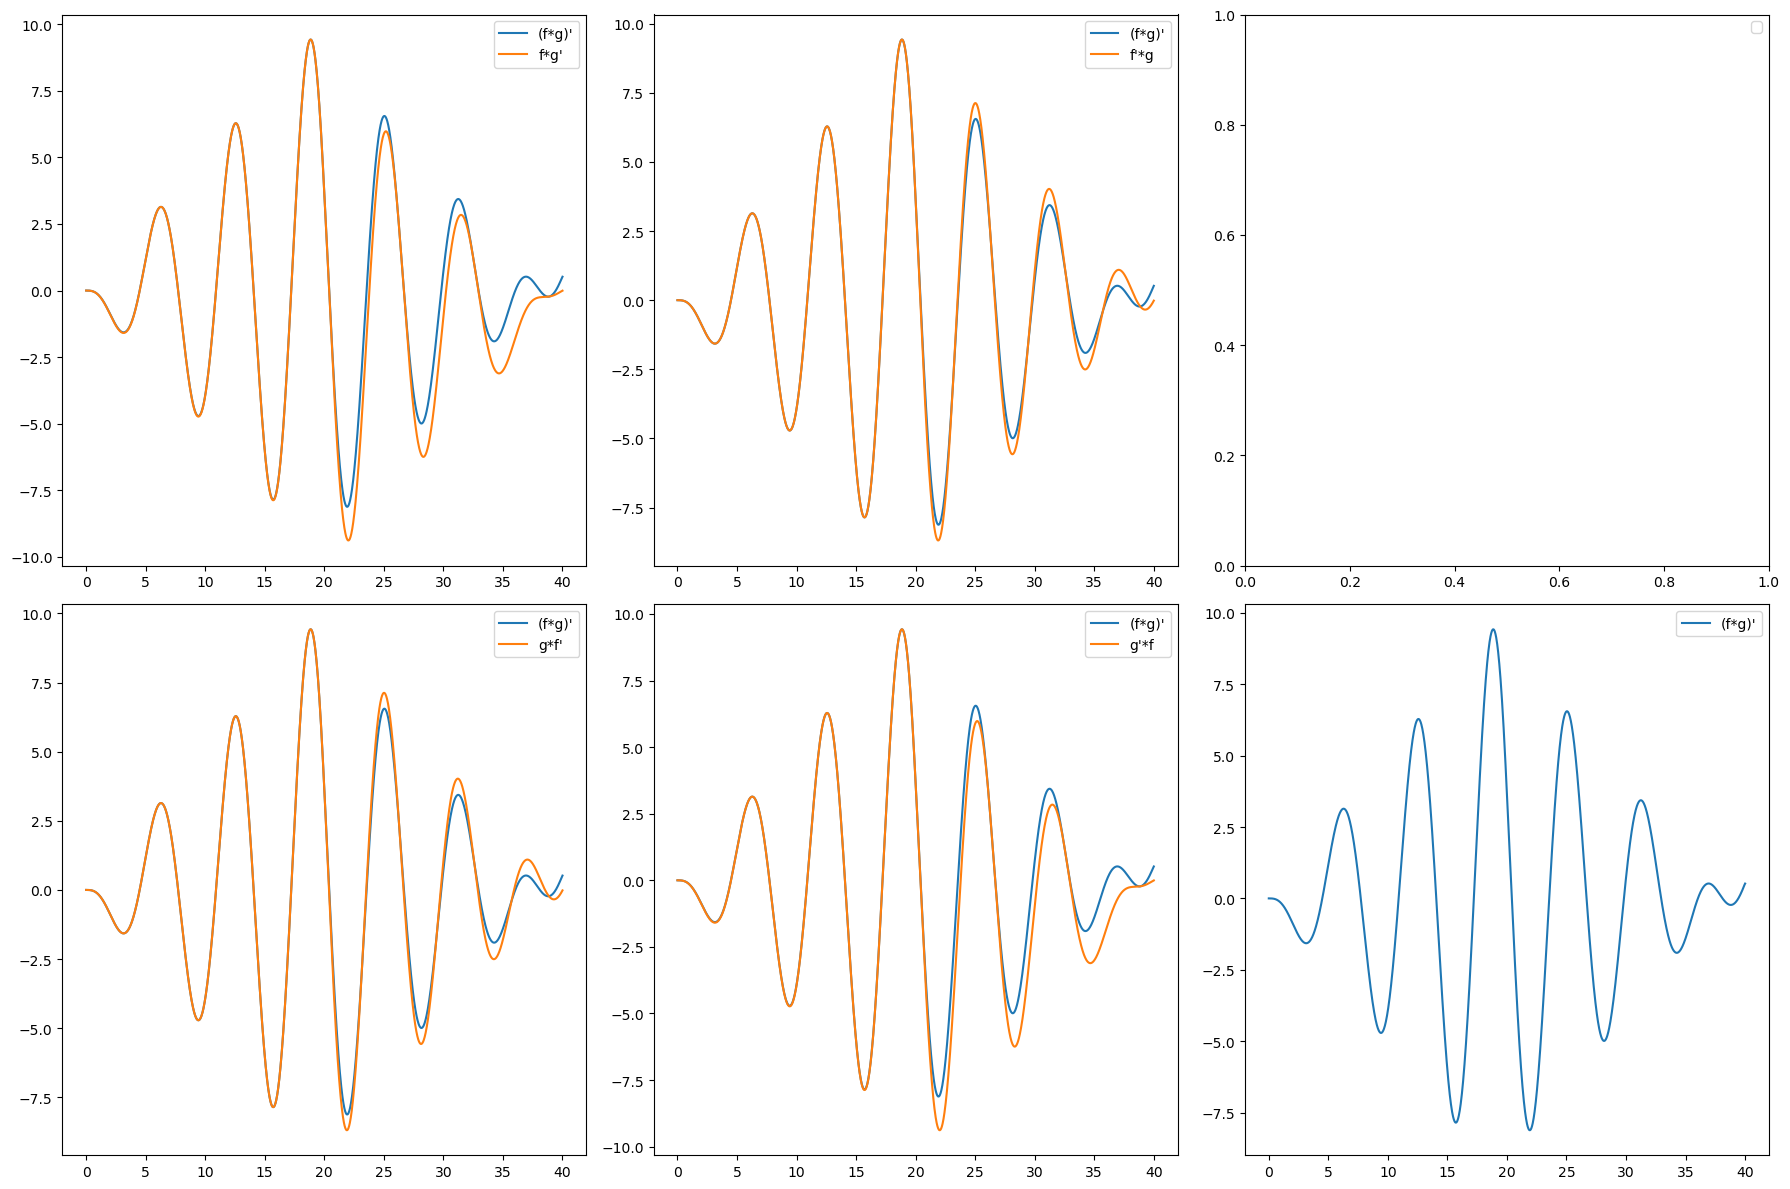

In [6]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Analytical functions
def f(x):
    return np.cos(x) - 1

def g(x):
    return np.sin(x)

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


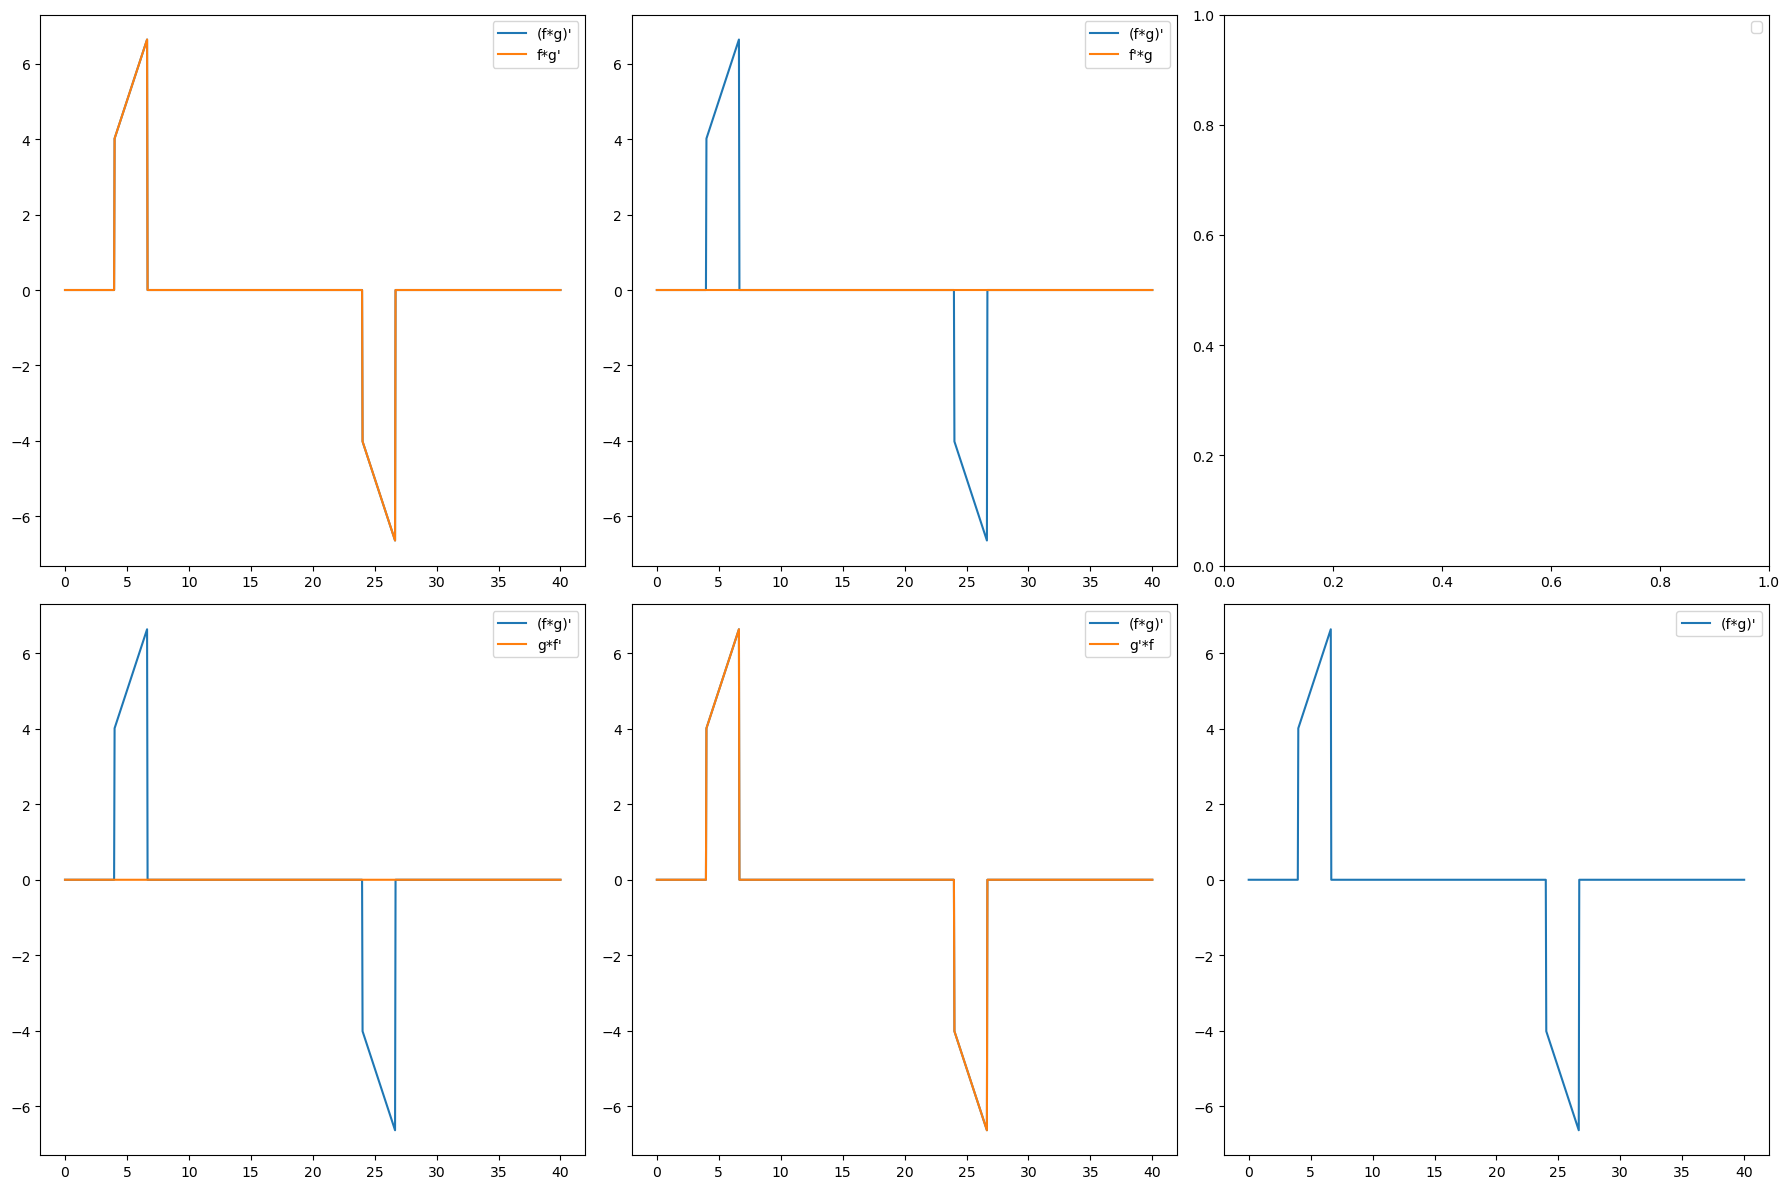

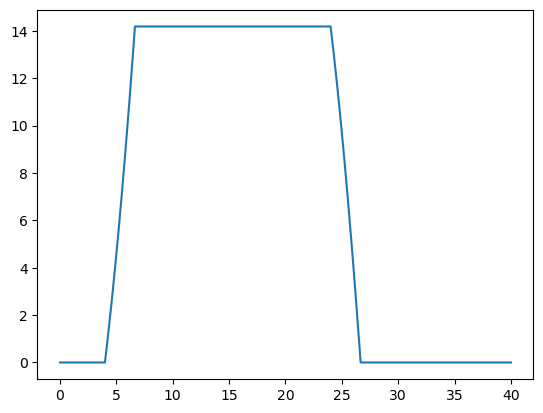

In [33]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    return np.heaviside(x , 1)

def g(x):
    return x * (np.heaviside(x - r /alpha, 1) - np.heaviside(x -  r / beta, 1))

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()

plt.plot(x_full, conv, label = "simple conv")
plt.show()


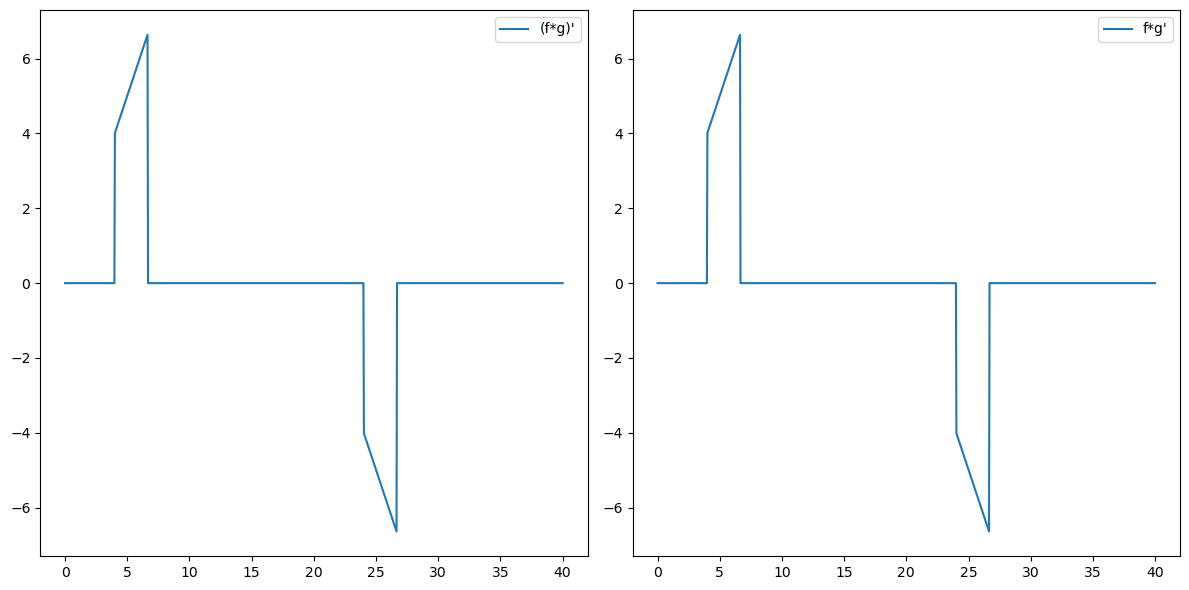

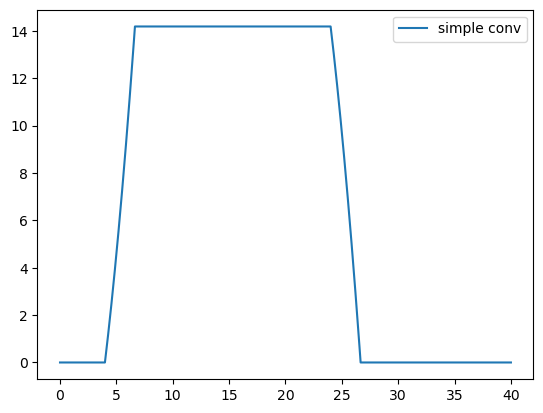

In [34]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    return np.heaviside(x , 1)

def g(x):
    return x * (np.heaviside(x - r / alpha, 1) - np.heaviside(x - r / beta, 1))

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in the first subplot
axs[0].plot(x_full, d_conv, label="(f*g)'")

# Plot f*g' in the second subplot
axs[1].plot(x_full, f_der_g, label="f*g'")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()

# Plot simple convolution
plt.plot(x_full, conv, label="simple conv")
plt.legend()
plt.show()


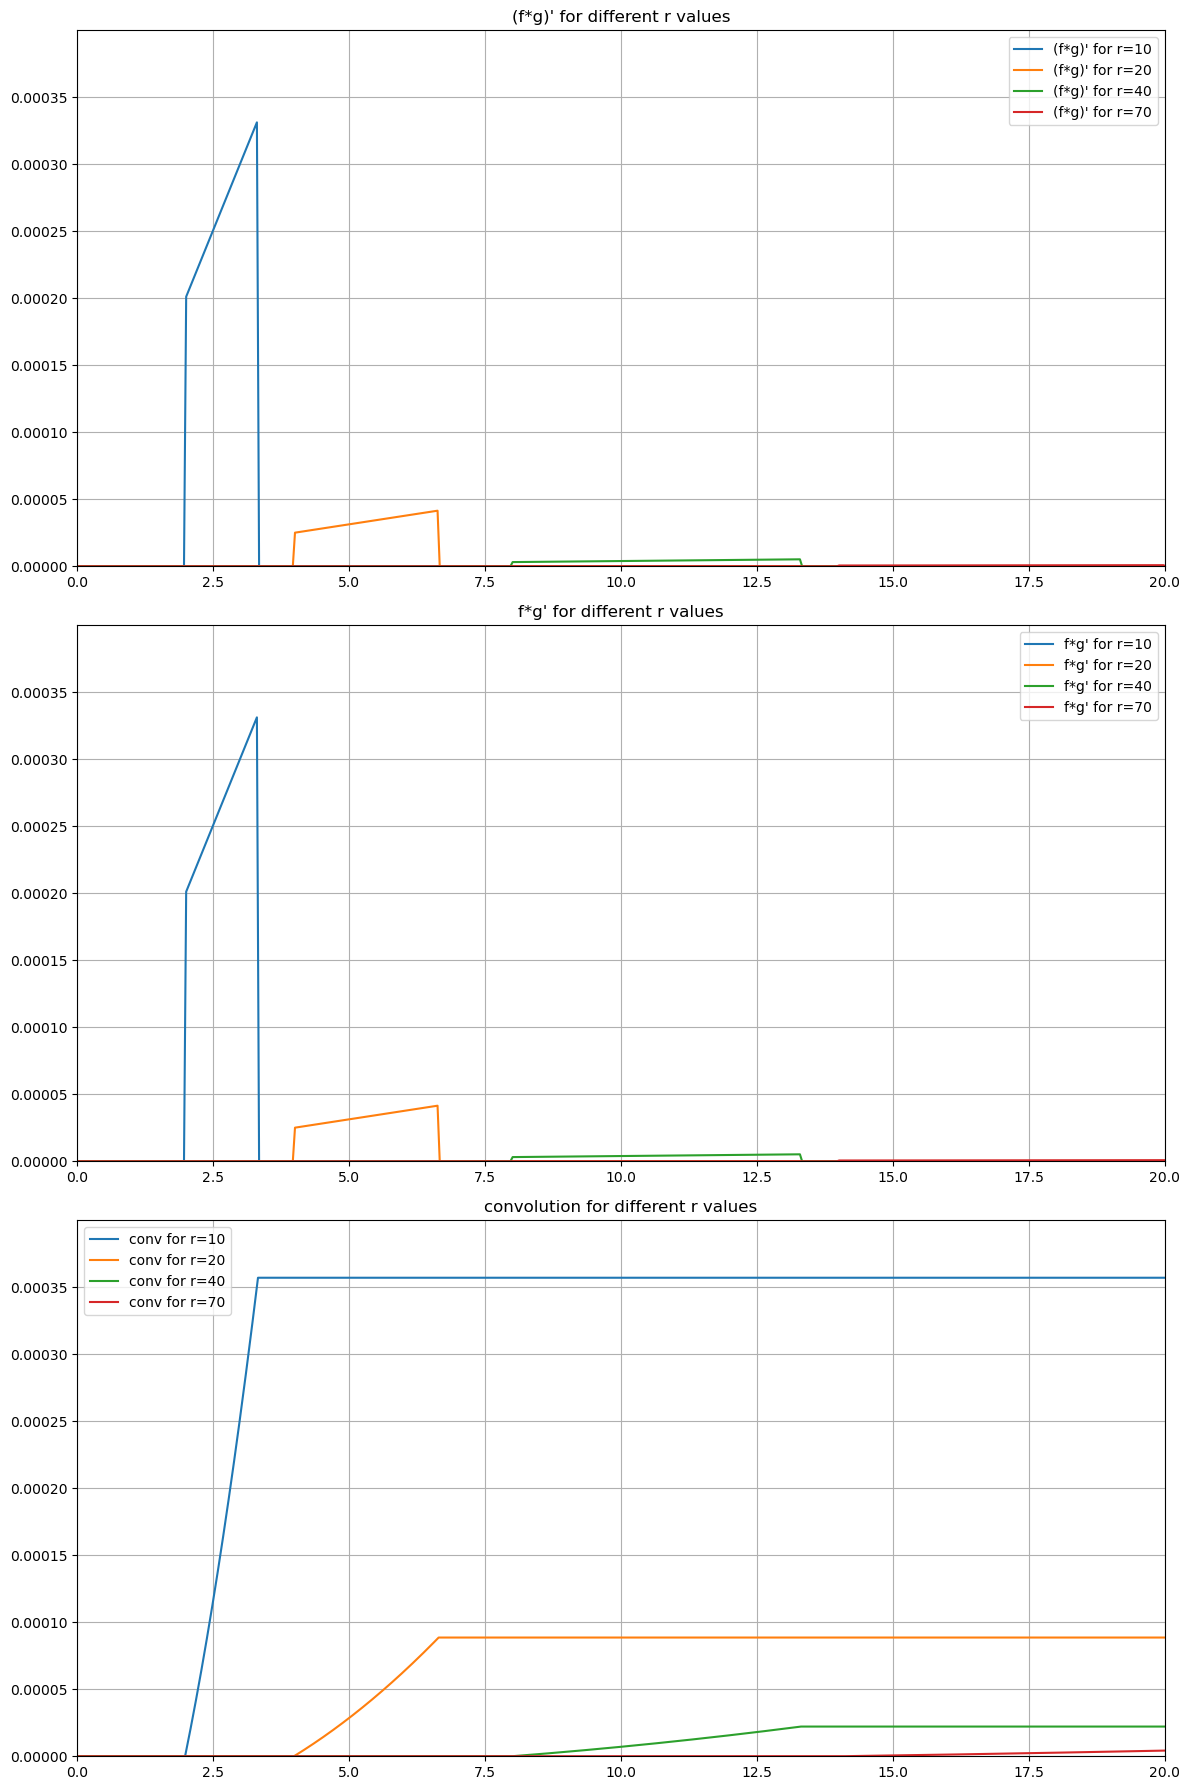

In [50]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

alpha = 5
beta = 3
r_values = [10, 20, 40, 70]

# Analytical functions
def f(x):
    return np.heaviside(x , 1)

def g(x, r):
    return x * (np.heaviside(x - r / alpha, 1) - np.heaviside(x - r / beta, 1)) * 1/ r **4

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# 範囲を調整
x_full = np.linspace(0, 40, len(x) * 2 - 1)

# 結果をプロットするためのフィギュアとサブプロットを作成
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

for r in r_values:
    # Using numpy's gradient function to calculate the derivatives
    f_prime_x = np.gradient(f(x), dx)
    g_prime_x = np.gradient(g(x, r), dx)

    # 関数f, gの畳み込みを計算します
    conv = signal.convolve(f(x), g(x, r), mode='full') * dx

    # 畳み込みの微分を計算します
    d_conv = np.gradient(conv, dx)

    # Compute convolution of f and derivative of g
    f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx

    # Plot (f*g)' and f*g' in the first and second subplots
    axs[0].plot(x_full, d_conv, label=f"(f*g)' for r={r}")
    axs[1].plot(x_full, f_der_g, label=f"f*g' for r={r}")

    # Plot simple convolution in the third subplot
    axs[2].plot(x_full, conv, label=f"conv for r={r}")

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.set_yticks(np.arange(0,0.0004, 0.00005)) 
    ax.grid(True)
    ax.set_xlim([0, 20])  # x軸の表示範囲を0から20までに制限
    ax.set_ylim([0, 0.0004])

axs[0].set_title("(f*g)' for different r values")
axs[1].set_title("f*g' for different r values")
axs[2].set_title("convolution for different r values")

plt.tight_layout()
plt.show()


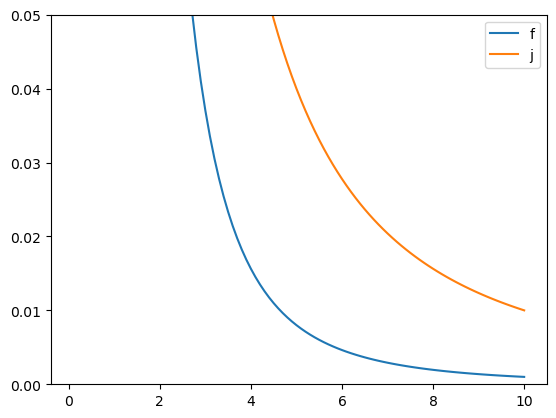

In [59]:
def func(t):
    return 1/ t**3

def junc(t):
    return 1/ t**2

t = np.linspace(0.1, 10, 100)
plt.plot(t, func(t), label = "f")
plt.plot(t, junc(t), label = "j")
plt.ylim([0, 0.05])
plt.legend()
plt.show()